In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import kaleido
import plotly.graph_objects as go

filename = r'C:\Users\Froxo\OneDrive\Escritorio\Corsika\Non_Binary_output_files_MC_Condor_DAT_1_Shower\Data_particle_1_energy_1.0E+03_angle_0_run_105.dat'
file = "Data_particle_1_energy_1.0E+03_angle_0_run_105.dat"

column_names = ['x', 'y', 'z', 't', 'px', 'py', 'pz', 'energy']

In [94]:
particles_df = pd.read_csv(filename, delimiter=" ", names=column_names, header=None)

In [95]:
# Asegurar de quitar todos los valores nulos
particles_df = particles_df.dropna().reset_index(drop=True)

# Creación de una nueva distancia "r" que especifica la distancia con respecto al centro de la cascada (o área de detectores)
particles_df['r'] = np.sqrt(particles_df['x']**2 + particles_df['y']**2)

# Ordenar las partículas desde la más cercana al centro a la más lejana (con respecto a la distancia r)
particles_df = particles_df.sort_values(by='r', ascending=True).reset_index(drop=True)

# Eliminar las columnas de los momentums 'px', 'py', 'pz' ya que no son necesarias
particles_df = particles_df.drop(columns=['px', 'z', 'py', 'pz'])

# Filtrar las partículas detectadas únicamente por el arreglo de detectores CONDOR
particles_df = particles_df[(particles_df['x'] >= -61) & (particles_df['x'] <= 61) &
                            (particles_df['y'] >= -56.5) & (particles_df['y'] <= 56.5)].reset_index(drop=True)

In [96]:
particles_df

,x,y,t,energy,r
0,-0.325312,-0.521238,39927.312,0.047714,0.614424
1,0.649002,-0.469373,39919.830,0.801235,0.800946
2,-0.629099,0.682110,39919.850,1.787400,0.927922
3,-0.899516,-0.310375,39920.310,0.008821,0.951558
4,-0.881529,-0.417814,39920.113,0.053145,0.975532
...,...,...,...,...,...
472,43.859460,54.472866,39960.527,0.011670,69.935294
473,51.725970,-52.489360,39929.113,0.010074,73.693344
474,53.668556,54.063774,39925.887,0.080939,76.178774
475,-57.045673,50.596570,39973.613,0.004314,76.251044


In [97]:
# Obtener el nombre del archivo para etiquetas
import re
match = re.search(r'particle_(\d+)_energy_(\S+)_angle_(\d+)_run_(\d+)', file)
if match:
    particle_id = int(match.group(1))
    incidence_energy = float(match.group(2))
    incidence_angle = int(match.group(3))
else:
    raise ValueError("Nombre de archivo no tiene el formato esperado")

# Agregar columnas de etiquetas
particles_df['particle_id'] = particle_id
particles_df['incidence_energy'] = incidence_energy
particles_df['incidence_angle'] = incidence_angle

# Reordenar las columnas
new_column_order = ['x', 'y', 'r', 't', 'energy', 'particle_id', 'incidence_energy', 'incidence_angle']
particles_df = particles_df[new_column_order]

In [98]:
# Normalización/Estandarización
# scaler = StandardScaler()  # Alternativamente, usa MinMaxScaler() si prefieres normalización entre 0 y 1
# particles_df[['x', 'y', 't', 'energy']] = scaler.fit_transform(particles_df[['x', 'y', 't', 'energy']])

In [99]:
# Manejo de outliers 
# En este caso, usamos el rango intercuartil para identificar outliers de energía y eliminarlos si están fuera de los límites
Q1 = particles_df.quantile(0.1)
Q3 = particles_df.quantile(0.9)
IQR = Q3 - Q1
# Mantener sólo las filas que no son outliers
particles_df = particles_df[~((particles_df < (Q1 - 1.5 * IQR)) | (particles_df > (Q3 + 1.5 * IQR))).any(axis=1)].reset_index(drop=True)

In [100]:
particles_df['t'] = particles_df['t'] - particles_df['t'].min()

particles_df = particles_df.drop(columns=['r'])

# Exportar el DataFrame binned_particles a un archivo CSV
particles_df.to_csv(f"final_matrix_data_particleid_{particle_id}_angle_{incidence_angle}_energy_{incidence_energy:.1e}.csv", index=False)

In [101]:
particles_df.sort_values(by='t', ascending=True).reset_index(drop=True)

,x,y,t,energy,particle_id,incidence_energy,incidence_angle
0,-1.647197,-0.382417,0.000,0.026683,1,1000.0,0
1,1.864792,0.615030,0.004,0.409120,1,1000.0,0
2,0.674300,-2.313032,0.014,0.602800,1,1000.0,0
3,1.592174,-1.706454,0.014,0.201752,1,1000.0,0
4,0.920664,0.452156,0.019,0.258683,1,1000.0,0
...,...,...,...,...,...,...,...
446,16.723963,34.522614,52.590,0.003041,1,1000.0,0
447,-23.341406,25.524406,53.387,0.001703,1,1000.0,0
448,-57.045673,50.596570,53.777,0.004314,1,1000.0,0
449,-29.421371,38.596310,59.184,0.003862,1,1000.0,0


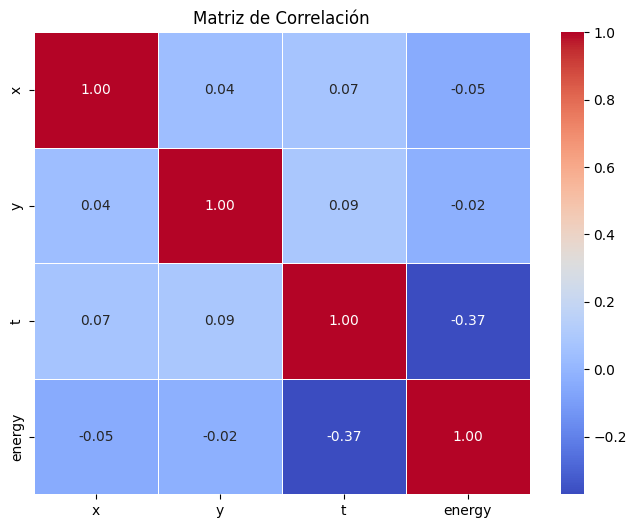

In [102]:
# Calcula la matriz de correlación
correlation_matrix = particles_df[['x', 'y', 't', 'energy']].corr()

# Configura el tamaño del gráfico
plt.figure(figsize=(8, 6))

# Crea el mapa de calor con seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Agrega título
plt.title('Matriz de Correlación')

# Muestra el gráfico
plt.show()

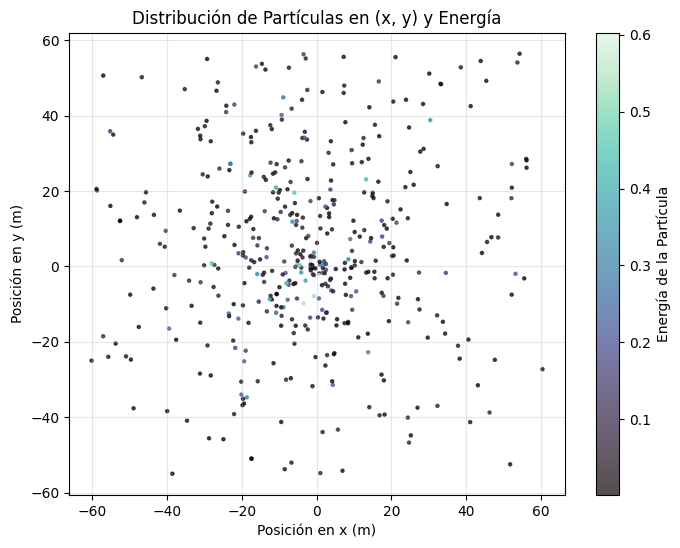

In [103]:
# Configuración del tamaño del gráfico
plt.figure(figsize=(8, 6))

# Crear un scatter plot para la distribución de las partículas en (x, y) y colorear por la energía
plt.scatter(particles_df['x'], particles_df['y'], c=particles_df['energy'], cmap='mako', s=5, alpha=0.7)

plt.grid(alpha=0.3)

# Agregar un color bar para indicar la escala de energía
plt.colorbar(label='Energía de la Partícula')

# Agregar etiquetas y título
plt.xlabel('Posición en x (m)')
plt.ylabel('Posición en y (m)')
plt.title('Distribución de Partículas en (x, y) y Energía')

# Mostrar el gráfico
plt.show()

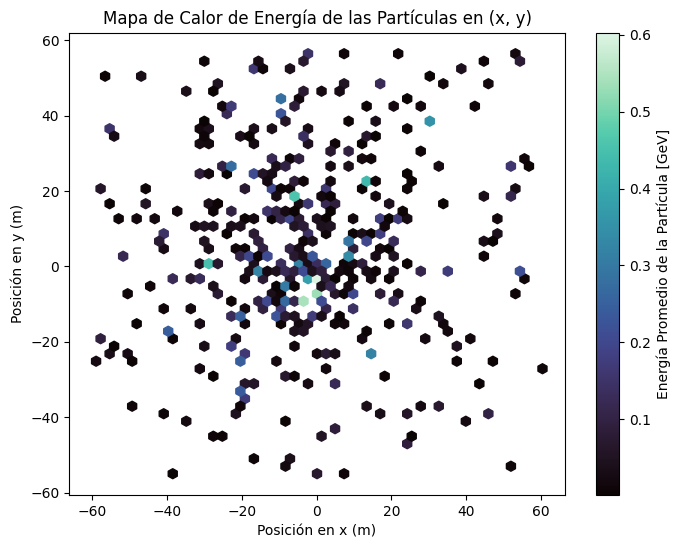

In [104]:
# Crear un mapa de calor usando un gráfico de hexbin
plt.figure(figsize=(8, 6))
hb = plt.hexbin(particles_df['x'], particles_df['y'], C=particles_df['energy'], gridsize=50, cmap='mako', reduce_C_function=np.mean)

# Agregar una barra de color para la escala de energía
plt.colorbar(hb, label='Energía Promedio de la Partícula [GeV]')

# Agregar etiquetas y título
plt.xlabel('Posición en x (m)')
plt.ylabel('Posición en y (m)')
plt.title('Mapa de Calor de Energía de las Partículas en (x, y)')

# Mostrar el gráfico
plt.show()

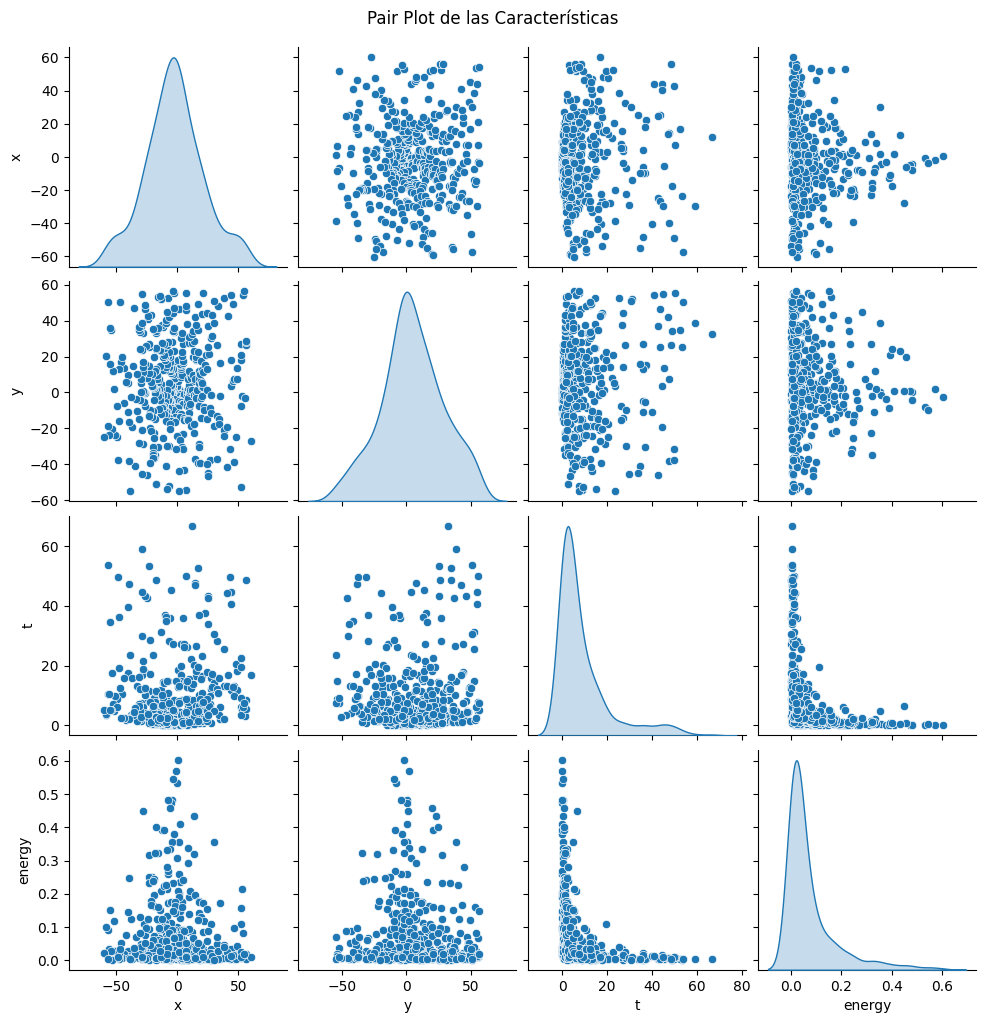

In [105]:
# Creación de Pairplot para ver la relación entre cada característica
sns.pairplot(particles_df[['x', 'y', 't', 'energy']], diag_kind='kde')
plt.suptitle('Pair Plot de las Características', y=1.02)
plt.show()

In [121]:
# Usamos np.floor() para que los valores negativos también se asignen al bin correcto
particles_df['x_bin'] = np.floor(particles_df['x']).astype(int)  # Bins de 1 metro en 'x'
particles_df['y_bin'] = np.floor(particles_df['y']).astype(int)  # Bins de 1 metro en 'y'

# Ahora creamos bins de tiempo en nanosegundos
time_bin_size = 1  # 1 nanosegundo
particles_df['t_bin'] = np.floor(particles_df['t'] / time_bin_size).astype(int)

# Agrupar por 'x_bin', 'y_bin' y 't_bin' para contar cuántas partículas caen en cada área y tiempo
binned_particles = particles_df.groupby(['x_bin', 'y_bin', 't_bin']).size().reset_index(name='particle_count')

# Exportar el DataFrame binned_particles a un archivo CSV
binned_particles.to_csv(f"binned_data_particleid_{particle_id}_angle_{incidence_angle}_energy_{incidence_energy:.1e}.csv", index=False)

In [122]:
# Visualizamos el DataFrame binalizado
binned_particles.sort_values(by='t_bin', ascending=True).reset_index(drop=True)

,x_bin,y_bin,t_bin,particle_count
0,-1,-8,0,1
1,2,1,0,1
2,-11,-13,0,1
3,2,0,0,1
4,-11,19,0,1
...,...,...,...,...
433,16,34,53,1
434,-24,25,53,1
435,-58,50,54,1
436,-30,38,59,1


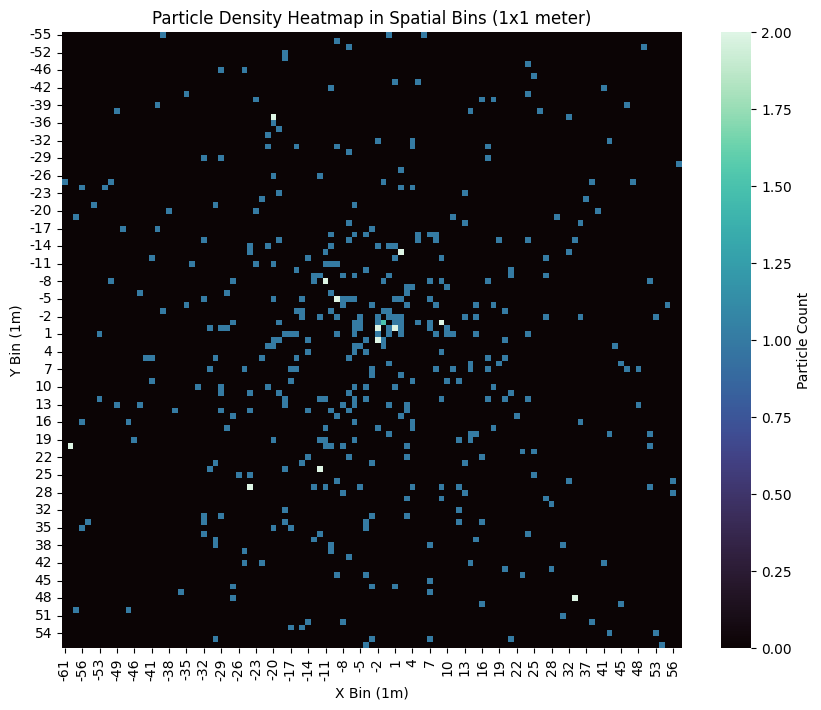

In [123]:
# Crear una tabla pivote para el heatmap (partículas en función de la posición espacial)
heatmap_data = binned_particles.pivot_table(index='y_bin', columns='x_bin', values='particle_count', fill_value=0)

# Graficar el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='mako', cbar_kws={'label': 'Particle Count'})
plt.title('Particle Density Heatmap in Spatial Bins (1x1 meter)')
plt.xlabel('X Bin (1m)')
plt.ylabel('Y Bin (1m)')
plt.savefig(f"2D_particle_distribution_particleid_{particle_id}_angle_{incidence_angle}_energy_{incidence_energy:.1e}.png")
plt.show()

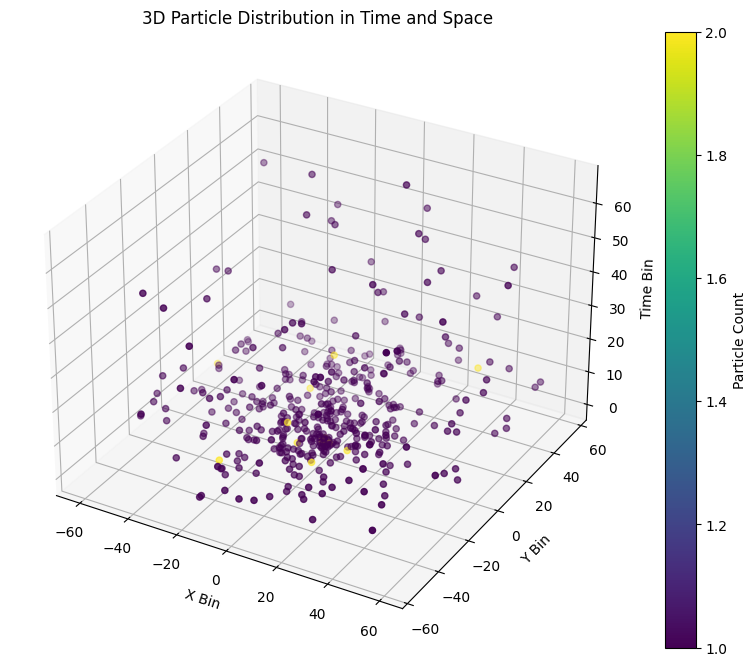

In [109]:
filtered_particles = binned_particles[binned_particles['particle_count'] >= 0]  # Filtrar partículas válidas

# Extraer los datos necesarios para las coordenadas y el color
x = filtered_particles['x_bin']
y = filtered_particles['y_bin']
z = filtered_particles['t_bin']
particle_count = filtered_particles['particle_count']

# Crear la figura y los ejes 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Crear el scatter plot
scatter = ax.scatter(x, y, z, c=particle_count, cmap='viridis', marker='o')

# Etiquetas de los ejes
ax.set_xlabel('X Bin')
ax.set_ylabel('Y Bin')
ax.set_zlabel('Time Bin')

# Añadir barra de color
cbar = fig.colorbar(scatter, ax=ax, label='Particle Count')

# Título
plt.title('3D Particle Distribution in Time and Space')

# Guardar el gráfico como PNG
plt.savefig(f"3D_particle_distribution_particleid_{particle_id}_angle_{incidence_angle}_energy_{incidence_energy:.1e}.png", dpi=300)

# Mostrar el gráfico
plt.show()

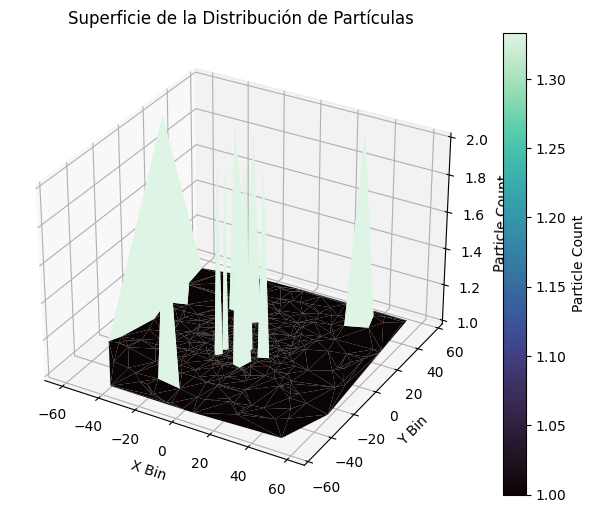

In [110]:
# Configuración del gráfico 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Crear un grid de las posiciones
x = binned_particles['x_bin']
y = binned_particles['y_bin']
z = binned_particles['t_bin']
c = binned_particles['particle_count']

# Usar el plot de superficie
img = ax.plot_trisurf(x, y, c, cmap='mako', edgecolor='none')

# Etiquetas
ax.set_xlabel('X Bin')
ax.set_ylabel('Y Bin')
ax.set_zlabel('Particle Count')
plt.colorbar(img, label='Particle Count')
plt.title('Superficie de la Distribución de Partículas')
plt.show()

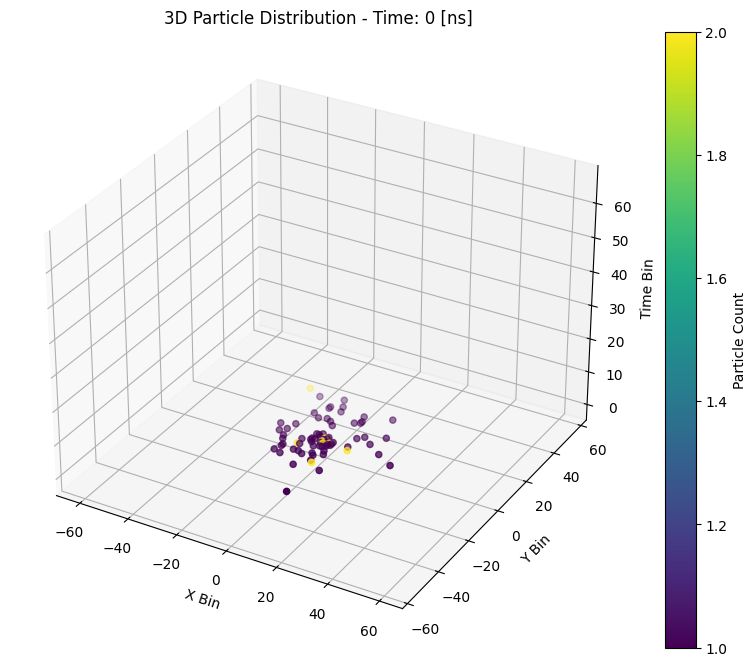

In [111]:
# Filtrar dataframe por cantidad de partículas
filtered_particles = binned_particles

# Configuración de la figura y el gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Configuración inicial del scatter plot con una barra de color
scatter = ax.scatter(filtered_particles['x_bin'], filtered_particles['y_bin'], filtered_particles['t_bin'], 
                     c=filtered_particles['particle_count'], cmap='viridis', marker='o')

# Etiquetas de los ejes
ax.set_xlabel('X Bin')
ax.set_ylabel('Y Bin')
ax.set_zlabel('Time Bin')

# Añadir la barra de color (solo una vez)
cbar = plt.colorbar(scatter, ax=ax, label='Particle Count')

# Función para actualizar el gráfico en cada frame de la animación
def update(frame):
    # Filtrar los datos para el frame actual
    current_bin_data = filtered_particles[filtered_particles['t_bin'] == frame]
    
    # Actualizar los datos del scatter plot
    scatter._offsets3d = (current_bin_data['x_bin'], current_bin_data['y_bin'], current_bin_data['t_bin'])
    scatter.set_array(current_bin_data['particle_count'])

    # Actualizar el título para mostrar el tiempo en nanosegundos
    ax.set_title(f'3D Particle Distribution - Time: {frame} [ns]')

# Crear la animación
anim = FuncAnimation(fig, update, frames=sorted(filtered_particles['t_bin'].unique()), interval=200, repeat=False)

# Para guardar la animación como un archivo
anim.save(f"particles_animation_3D_particleid_{particle_id}_angle_{incidence_angle}_energy_{incidence_energy:.1e}.gif")

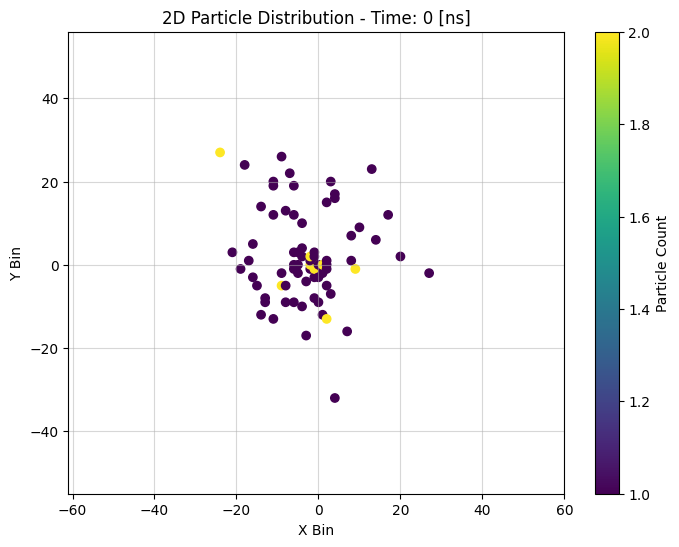

In [112]:
# Filtrar dataframe por cantidad de partículas
filtered_particles = binned_particles[binned_particles['particle_count'] > 0]

# Configurar la figura y el scatter plot inicial
fig, ax = plt.subplots(figsize=(8, 6))

# Crear el scatter plot inicial (vacío)
scatter = ax.scatter([], [], c=[], cmap='viridis', vmin=filtered_particles['particle_count'].min(), 
                     vmax=filtered_particles['particle_count'].max())

# Etiquetas
ax.set_xlabel('X Bin')
ax.set_ylabel('Y Bin')
plt.title('Particle Distribution Over Time')
plt.grid(alpha=0.5)

# Añadir barra de color fuera de la función de actualización (fija)
cbar = plt.colorbar(scatter, ax=ax, label='Particle Count')

# Configurar los límites del gráfico según los datos
ax.set_xlim(filtered_particles['x_bin'].min(), filtered_particles['x_bin'].max())
ax.set_ylim(filtered_particles['y_bin'].min(), filtered_particles['y_bin'].max())

# Función para actualizar el gráfico en cada frame de la animación
def update(frame):
    current_bin_data = filtered_particles[filtered_particles['t_bin'] == frame]
    scatter.set_offsets(np.c_[current_bin_data['x_bin'], current_bin_data['y_bin']])
    scatter.set_array(current_bin_data['particle_count'])
    # Actualizar el título para mostrar el tiempo en nanosegundos
    ax.set_title(f'2D Particle Distribution - Time: {frame} [ns]')

# Crear la animación
anim = FuncAnimation(fig, update, frames=sorted(filtered_particles['t_bin'].unique()), interval=200, repeat=False)

anim.save(f'particles_animation_2D_particleid_{particle_id}_angle_{incidence_angle}_energy_{incidence_energy:.1e}.gif')